In [65]:
# Imports
import numpy as np
import torch

from phimal_utilities.data import Dataset
from phimal_utilities.data.burgers import BurgersDelta
from phimal_utilities.analysis import load_tensorboard

from DeePyMoD_SBL.deepymod_torch.library_functions import library_1D_in
from DeePyMoD_SBL.deepymod_torch.DeepMod import DeepModDynamic
from DeePyMoD_SBL.deepymod_torch.training import train_dynamic
from DeePyMoD_SBL.deepymod_torch.estimators import Threshold, Clustering, ClusteringL1, PDEFIND
from pysindy.optimizers import SINDyOptimizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
np.random.seed(42)
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [84]:
v = 0.1
A = 1.0

# Making grid
x = np.linspace(-3, 4, 100)
t = np.linspace(0.5, 5.0, 50)
x_grid, t_grid = np.meshgrid(x, t, indexing='ij')

dataset = Dataset(BurgersDelta, v=v, A=A)
X_train, y_train, rand_idx = dataset.create_dataset(x_grid.reshape(-1, 1), t_grid.reshape(-1, 1), n_samples=1000, noise=0.2, random=True, return_idx=True)

In [85]:
# Making data
estimator = PDEFIND()

config = {'n_in': 2, 'hidden_dims': [30, 30, 30, 30, 30], 'n_out': 1, 'library_function':library_1D_in, 'library_args':{'poly_order':2, 'diff_order': 3}, 'sparsity_estimator': estimator}
model = DeepModDynamic(**config)
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.999), amsgrad=True)

In [86]:
train_dynamic(model, X_train, y_train, optimizer, 5000, stopper_kwargs={'ini_epoch': 1000, 'patience': 50}, log_dir='runs/testing/')

| Iteration | Progress | Time remaining |     Loss |      MSE |      Reg |    L1 norm |
       1025     20.50%             103s   -9.25e+00   1.54e-03   2.98e-05   3.12e+00 Updating mask.
       1125     22.50%             113s   -9.13e+00   1.58e-03   1.53e-04   1.53e+00 Updating mask.
       1275     25.50%              84s   -9.20e+00   1.56e-03   8.33e-05   1.52e+00 Updating mask.
       1475     29.50%              96s   -9.25e+00   1.54e-03   4.04e-05   1.52e+00 Updating mask.
       1725     34.50%              57s   -9.27e+00   1.53e-03   3.25e-05   1.51e+00 Updating mask.
Sparsity has been applied 5 times


In [87]:
model.sparsity_estimator.coef_

array([ 0.        ,  0.        ,  0.58205491,  0.        ,  0.        ,
       -0.92571151,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [88]:
model.constraints.coeff_vector

[tensor([[ 0.0976],
         [-0.9917]], grad_fn=<MmBackward>)]

In [98]:
df_part1 = load_tensorboard('runs/testing/')

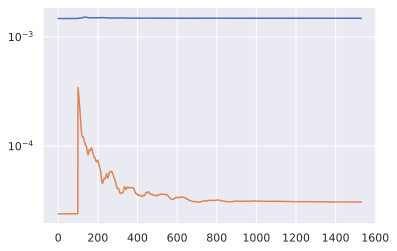

In [99]:
plt.semilogy(df_part1.index, df_part1['MSE_0'])
plt.semilogy(df_part1.index, df_part1['Regression_0'])

In [100]:
df_part1.keys()

Index(['Total_loss', 'MSE_0', 'Regression_0', 'L1_0', 'coeff_0_0', 'coeff_0_1',
       'coeff_0_2', 'coeff_0_3', 'coeff_0_4', 'coeff_0_5', 'coeff_0_6',
       'coeff_0_7', 'coeff_0_8', 'coeff_0_9', 'coeff_0_10', 'coeff_0_11',
       'scaled_coeff_0_0', 'scaled_coeff_0_1', 'scaled_coeff_0_2',
       'scaled_coeff_0_3', 'scaled_coeff_0_4', 'scaled_coeff_0_5',
       'scaled_coeff_0_6', 'scaled_coeff_0_7', 'scaled_coeff_0_8',
       'scaled_coeff_0_9', 'scaled_coeff_0_10', 'scaled_coeff_0_11'],
      dtype='object')

(0.5, 6)

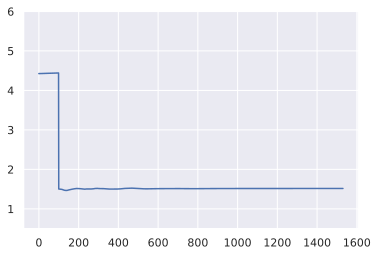

In [101]:
plt.plot(df_part1.index, df_part1['L1_0'])
plt.ylim([0.5, 6])

In [102]:
coeff_keys = [key for key in df_part1.keys() if key[:5]=='coeff']
scaled_coeff_keys = [key for key in df_part1.keys() if key[:6]=='scaled']

In [103]:
coeff_keys

['coeff_0_0',
 'coeff_0_1',
 'coeff_0_2',
 'coeff_0_3',
 'coeff_0_4',
 'coeff_0_5',
 'coeff_0_6',
 'coeff_0_7',
 'coeff_0_8',
 'coeff_0_9',
 'coeff_0_10',
 'coeff_0_11']

(-2, 2)

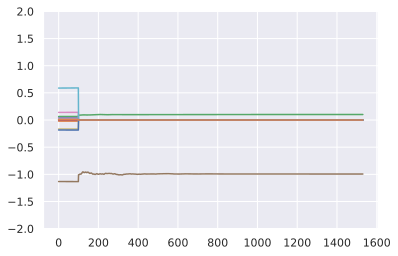

In [104]:
plt.plot(df_part1[coeff_keys])
plt.ylim([-2, 2])

(0, 1)

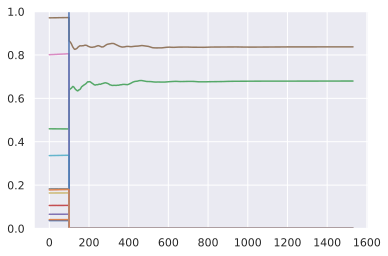

In [105]:
plt.plot(np.abs(df_part1[scaled_coeff_keys]))
plt.ylim([0, 1])

(0, 1)

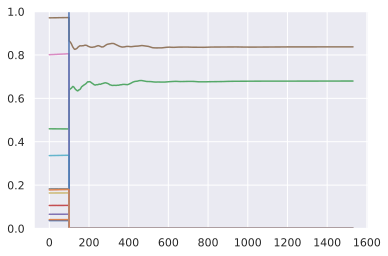

In [107]:
plt.plot(np.abs(df_part1[scaled_coeff_keys]))
plt.ylim([0, 1])

In [108]:
active_map = df_part1[coeff_keys][::10]
active_map[active_map!=0.0] = 1.0

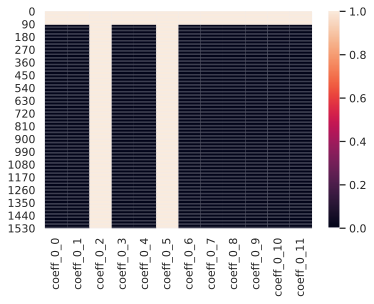

In [109]:
sns.heatmap(active_map)